In [0]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Import Libraries

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D, AveragePooling2D
from keras.utils import plot_model
import scipy.ndimage
import os
import sys
np.set_printoptions(threshold=sys.maxsize)

CURR_DIR = "/content/drive/My Drive/input_analysis"

Using TensorFlow backend.


# Import MNIST

In [0]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
 
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


# Reshape the input

In [0]:
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],x_train.shape[2],1))
print(x_train.shape)
x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],x_test.shape[2],1))
print(x_test.shape)
x_train = x_train/255
x_test  = x_test/255
x_train = x_train.astype('float')
x_test  = x_test.astype('float')

(60000, 28, 28, 1)
(10000, 28, 28, 1)


#Increase size of images from 28x28 to 32x32


In [0]:
x_train = np.pad(x_train, ((0,0),(2,2),(2,2), (0,0)), 'constant')
x_test = np.pad(x_test, ((0,0),(2,2),(2,2), (0,0)), 'constant')

print("Updated Image Shape: {}".format(x_train.shape))

Updated Image Shape: (60000, 32, 32, 1)


# Implement LeNet

In [0]:
model = Sequential()

model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
model.add(AveragePooling2D())

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))

model.add(GlobalAveragePooling2D())
# uncomment below and comment above line for actual model
"""
model.add(AveragePooling2D())

model.add(Flatten())

model.add(Dense(units=120, activation='relu'))

model.add(Dense(units=84, activation='relu'))
"""

model.add(Dense(units=10, activation = 'softmax'))

#Fit Model

In [0]:
model.summary()
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
model.fit(x_train,y_train,batch_size=32,epochs=5,validation_split=0.1,shuffle=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d_1 (Average (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
global_average_pooling2d_1 ( (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
Total params: 1,110
Trainable params: 1,110
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 54000 samp

#Run model on test data

In [0]:
score = model.evaluate(x_test, y_test, verbose=False) 
model.metrics_names
print('Test score: ', score[0])    #Loss on test
print('Test accuracy: ', score[1])
model.summary()

model.save(os.path.join(CURR_DIR, "lenet_truncated.h5"))

Test score:  0.9413778934478759
Test accuracy:  0.6973
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d_1 (Average (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
global_average_pooling2d_1 ( (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
Total params: 1,110
Trainable params: 1,110
Non-trainable params: 0
_________________________________________________________________


## Context Activation Mapping

In [0]:
from keras.models import Model
import scipy as sp
#gap_weights = model.layers[-1].get_weights()[0]
#gap_weights.shape

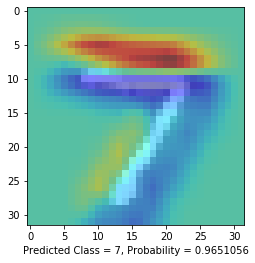

In [0]:
def cam():
  gap_weights = model.layers[-1].get_weights()[0]
  cam_model = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))
  features,results = cam_model.predict(x_test)

  for idx in range(5):
    features_for_one_img = features[idx,:,:,:]
    #print(features_for_one_img.shape)
    pred = np.argmax(results[idx])
    # cam_features = features_for_one_img
    x_scale = x_train.shape[1] / features_for_one_img.shape[0]
    y_scale = x_train.shape[2] / features_for_one_img.shape[1]
    #cam_features = scipy.ndimage.zoom(features_for_one_img, (32,32,1), order=1)
    # print(features_for_one_img.shape)
    cam_features = scipy.ndimage.zoom(features_for_one_img, (x_scale,y_scale,1), order=1)

    
    plt.figure(facecolor='white')
    cam_weights = gap_weights[:,pred]
    cam_output  = np.dot(cam_features,cam_weights)

    # print(cam_output)

    buf = 'Predicted Class = ' +str( pred )+ ', Probability = ' + str(results[idx][pred])
    plt.xlabel(buf)
    plt.imshow(np.squeeze(x_test[idx],-1),alpha=0.5, cmap='gray')
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
    #plt.imshow(cam_output, cmap='jet')
    
    plt.show()
    break

cam()

(32, 32, 1)
(13, 13)
32
32


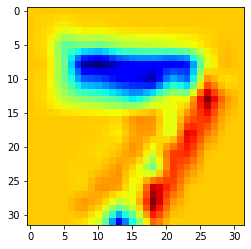

In [0]:
from keras import backend as K
from vis.utils import utils
import cv2

def grad_cam():
  class_output = model.output[:, 7]

  # layer output
  convolution_output = model.get_layer('conv2d_6').output

  # get gradients
  grads = K.gradients(class_output, convolution_output)[0]

  # get convolution output and gradients for input
  gradient_function = K.function([model.input], [convolution_output, grads])

  print(x_test[0].shape)
  # output, grads_val = gradient_function([x_test[0]])
  output, grads_val = gradient_function([(x_test[0])[np.newaxis,...]])
  output, grads_val = output[0], grads_val[0]

  #print(output)
  #rint(grads_val)
  weights = np.mean(grads_val, axis=(0, 1))
  cam = np.dot(output, weights)

  print(cam.shape)
  print(x_test.shape[1])
  print(x_test.shape[2])

  # create heat map
  x_scale = x_test.shape[1] / cam.shape[0]
  y_scale = x_test.shape[2] / cam.shape[1]
  cam = scipy.ndimage.zoom(cam, (x_scale,y_scale), order=1)

  #cam = np.maximum(cam, 0)
  #heatmap = cam / np.max(cam)

  # Return to BGR [0..255] from the preprocessed image
  #image_rgb = (x_test[0])[0, :]
  #image_rgb -= np.min(image_rgb)
  #image_rgb = np.minimum(image_rgb, 255)

  
  #cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
  #cam = np.float32(cam) + np.float32(image_rgb)
  #cam = 255 * cam / np.max(cam)

  plt.imshow(cam, cmap = 'jet')
  # plt.imshow(heatmap)
  
grad_cam()

In [0]:
!nvidia-smi

Tue Nov 12 16:20:45 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    31W / 250W |    611MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  